# INDEX

In [ ]:
# Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_elasticsearch import ElasticsearchStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)
documents=doc_splits

embeddings = OllamaEmbeddings(model="all-minilm")


db = FAISS.from_documents(documents, embeddings)

retriever = db.as_retriever()


USER_AGENT environment variable not set, consider setting it to identify your requests.


# 2. Retrieval Grader

In [ ]:
# Retrieval Grader
local_llm = "gemma3:4b"
# local_llm="phi3.5"

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)


prompt = PromptTemplate(
    template="""
You are a grader checking if a retrieved document is relevant to a user's question.

A document is relevant if it contains keywords or information clearly related to the question.
This is not a strict test—your goal is to filter out obviously unrelated results.

Return a binary relevance score:
- Use "yes" if the document is relevant.
- Use "no" if the document is not relevant.

Output the result as a JSON object with a single key "score". Do not include any explanation or additional text.

Document:
{document}

Question:
{question}

Your answer (JSON only):
""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "what is an agent?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

C:\Users\BS00728\AppData\Local\Temp\ipykernel_25400\3703970419.py:10: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model=local_llm, format="json", temperature=0)


{'score': 'yes'}


In [ ]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

# 3. Generator

In [ ]:
# Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
You are an assistant for question-answering tasks.

Use the provided context to answer the user's question. If the answer is not in the context, respond with "I don't know."
Question: {question}
Context: {context}
Answer:
""",
    input_variables=["question", "context"],
)

llm = ChatOllama(model=local_llm, temperature=0.7)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "what is an agent?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


Okay, let's break down the provided text and synthesize the key information about LLM-powered autonomous agents.

**Core Concept:**

The text describes the development of autonomous agents built around Large Language Models (LLMs). These agents are designed to perform complex tasks by combining reasoning, tool usage, and memory.

**Key Components of the Agent Architecture:**

1.  **LLM as the "Brain":** The LLM serves as the core reasoning engine, responsible for understanding the user's goals, planning actions, and generating instructions.

2.  **Tool Use:** Agents are equipped to interact with external tools (APIs) to access information, perform calculations, or control external systems. This is a critical element for extending the agent's capabilities beyond the LLM's inherent knowledge.

3.  **Memory Systems:**
    *   **Short-Term Memory:**  Leverages in-context learning – the LLM’s ability to retain information from previous interactions within a single prompt.
    *   **Long-Ter

# 4. Hallucination Grader

In [ ]:
# Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)


prompt = PromptTemplate(
    template="""
You are a grader assessing whether an answer is grounded in a provided set of facts.

Return a binary score:
- Use "yes" if the answer is supported by the facts.
- Use "no" if it is not.

Output your answer as a JSON object with a single key: "score". Do not include any explanation or additional text.

Facts:
-------
{documents}
-------

Answer:
{generation}

output example:
{{
  "score": "yes" # or "no"
}}

Your evaluation (JSON only):
""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})



{'score': 'yes'}

# Answer Grader

In [ ]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)


prompt = PromptTemplate(
    template="""
You are a grader assessing whether an answer is useful in resolving a user's question.

Return a binary score:
- Use "yes" if the answer is helpful in addressing the question.
- Use "no" if it is not.

Output your answer as a JSON object with a single key: "score". Do not include any explanation or additional text.

Answer:
-------
{generation}
-------

Question:
{question}

output example:
{{
  "score": "no" # or "yes"
}}

Your evaluation (JSON only):
""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

# 5. Router

In [ ]:
# Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""
You are an expert at routing a user question to either a vectorstore or a web search.

Use **vectorstore** if the question is about:
- LLM agents
- Prompt engineering
- Adversarial attacks

You do not need to be strict about exact keywords—choose vectorstore if the topic is clearly related.
Otherwise, use **web_search**.

Return your decision as a JSON object with a single key: "datasource".
Valid values: "vectorstore" or "web_search".
Do not include any explanation or additional text. Never leave it blank.

Question to route:
{question}

{{
    "datasource": "web_search" # or "vectorstore"
}}

Your response (JSON only):
""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "tell me about ai agents"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))


C:\Users\BS00728\AppData\Local\Temp\ipykernel_25400\388845050.py:40: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


{'datasource': 'vectorstore'}


# 6. Web Search

In [ ]:
# Search
import os
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_api_key = os.getenv("TAVILY_API_KEY")
web_search_tool = TavilySearchResults(k=3,tavily_api_key=tavily_api_key)


In [ ]:
web_search_tool.invoke({"query": "tell me about ai agents"})

[{'url': 'https://en.wikipedia.org/wiki/Intelligent_agent',
  'content': 'In the context of generative artificial intelligence, AI agents (also referred to as compound AI systems) are a class of intelligent agents distinguished by their ability to operate autonomously in complex environments. They possess several key attributes, including complex goal structures, natural language interfaces, the capacity to act independently of user supervision, and the integration of software tools or planning systems. Their control flow is frequently driven by large language [...] In artificial intelligence, an intelligent agent is an entity that perceives its environment, takes actions autonomously to achieve goals, and may improve its performance through machine learning or by acquiring knowledge. Leading AI textbooks define artificial intelligence as the "study and design of intelligent agents," emphasizing that goal-directed behavior is central to intelligence. [...] A specialized subset of intel

# 7. Control Flow

In [ ]:
from pprint import pprint
from typing import List

import time

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph

# State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


# Nodes


def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


# Conditional edge


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


# Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    print("documents: ", documents)
    print("generation: ", generation)
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    print("score: ", score)
    # Check hallucination
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae


# 8. Build Graph

In [ ]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)


In [ ]:
from pprint import pprint

# Compile
app = workflow.compile()
inputs = {"question": "What is agent"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])


---ROUTE QUESTION---
What is agent
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
documents:  [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM

In [ ]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	websearch(websearch)
	retrieve(retrieve)
	grade_documents(grade_documents)
	generate(generate)
	__end__([<p>__end__</p>]):::last
	retrieve --> grade_documents;
	websearch --> generate;
	__start__ -.-> websearch;
	__start__ -. &nbsp;vectorstore&nbsp; .-> retrieve;
	grade_documents -.-> websearch;
	grade_documents -.-> generate;
	generate -. &nbsp;useful&nbsp; .-> __end__;
	generate -. &nbsp;not useful&nbsp; .-> websearch;
	generate -. &nbsp;not supported&nbsp; .-> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



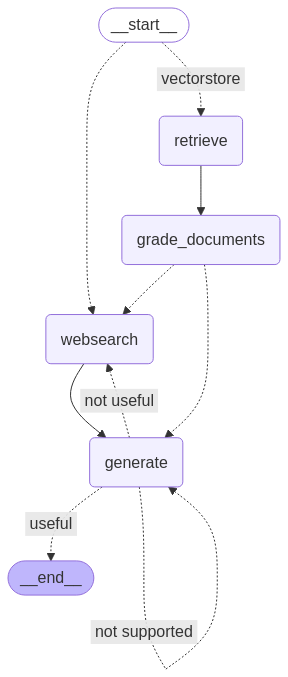

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)